In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Colab Notebooks/dna/week6

/content/drive/MyDrive/Colab Notebooks/dna/week6


In [3]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu' # device 배정
torch.manual_seed(42)
if device == 'cuda':
  torch.cuda.manual_seed_all(42)
device

'cuda'

# 1. 데이터 셋 준비하기

In [11]:
import torch.nn as nn

# 하이퍼 파라미터
batch_size = 8
lr = 0.0001
epochs = 50
optimizer_name = 'adam'
model_name = 'resnet50'
criterion = nn.CrossEntropyLoss().to(device) # cost function

In [5]:
from dataset import Custom_dataset as C
from torch.utils.data import Dataset, DataLoader
import cv2
import os 
import torch
import torchvision
from torchvision import transforms # 이미지 데이터 augmentation
import glob
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2 # albumentations 텐서화 함수

root_path = '/content/drive/MyDrive/Colab Notebooks/dna/week6/original-1'

train_transforms = A.Compose([
    A.Resize(224,224),
    A.Transpose(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=20, val_shift_limit=20, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
    A.ChannelShuffle(),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0), # 이미지넷 데이터셋 통계값으로 Normalize
    A.CoarseDropout(p=0.5),
    ToTensorV2()
])

test_transforms = A.Compose([
    A.Resize(224,224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0), # 텐서타입은 안해줌
    ToTensorV2() # Normalize를 먼저하고 tensor화를 진행해야한다.
])

### Pytorch 데이터 클래스 생성
train_class = C(root_path=root_path, mode='train', transforms=train_transforms)
valid_class = C(root_path=root_path, mode='valid', transforms=test_transforms)
test_class = C(root_path=root_path, mode='test', transforms=test_transforms)

### Pytorch BatchLoader 생성 (학습에 이용할 최종 dataloader)
# from torch.utils.data import DataLoader as DataLoader

train_loader = DataLoader(train_class, batch_size=batch_size, shuffle = True, num_workers=0)
valid_loader = DataLoader(valid_class, batch_size=batch_size, shuffle = False, num_workers=0)
test_loader = DataLoader(test_class, batch_size=batch_size, shuffle = False, num_workers=0)

# 2.모델 불러오기

In [6]:
from torchvision import models # 모델 라이브러리 함수

resnet_50 = models.resnet50(pretrained=True).to(device) # 선행학습 여부

# finetuning
import torch.nn as nn # 파이토치 뉴럴네트워크 layer 라이브러리
resnet_50.fc = nn.Linear(resnet_50.fc.in_features, 3).to(device)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [7]:
from torchsummary import summary # 모델 아키텍쳐 확인하는 함수

summary(resnet_50, input_size = (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [8]:
optimizer = torch.optim.Adam(resnet_50.parameters(), lr = lr, weight_decay = 1e-8)

# 3,모델 학습시키고 모델저장

In [9]:
import numpy as np

In [12]:

from tqdm import tqdm
from tensorflow import summary
from torch.utils.tensorboard import SummaryWriter
import argparse
import logging
from pathlib import Path
from torch import optim
import numpy as np

train_acc_lst, train_loss_lst, test_acc_lst, test_loss_lst= [], [], [], []

epochs = 50
model_name = 'resnet50'
state={}

for epoch in range(1, epochs+1):

  train_loss = 0.0
  total = 0
  correct = 0
  train_acc = 0
  
  resnet_50.train()
  for i, (train_img, train_label) in enumerate(train_loader):
    # gpu에 할당
    train_img = train_img.to(device)
    train_label = train_label.to(device)

    output = resnet_50(train_img) # 모델에 입력

    optimizer.zero_grad( set_to_none = True ) # 계산했던 가중치 초기화    
    loss = criterion(output, train_label)
    loss.backward() # 미분
    optimizer.step() # 학습

    # loss & acc
    train_loss += loss.item()
    _, predictions = torch.max(output.data ,dim = 1)
   
    total += train_label.size(0)
    correct += (predictions == train_label).sum().item()
    train_acc += 100 * (correct / total)

  train_loss = round(train_loss/(i+1), 3) # 소수점 반올림
  train_acc = round(train_acc/(i+1), 3)
  print(f'Trainset {epoch}/{epochs} Loss : {train_loss}, Accuracy : {train_acc}%')
  train_acc_lst.append(train_acc)
  train_loss_lst.append(train_loss)

  # -------------------------------------------------------------------------------------
  test_loss = 0.0
  corrects = 0
  totals = 0
  test_acc = 0

  resnet_50.eval()
  for i, (valid_img, valid_label) in enumerate(valid_loader):
        # gpu에 할당
    valid_img = valid_img.to(device)
    valid_label = valid_label.to(device)

    outputs = resnet_50(valid_img) # 모델에 입력
    losses = criterion(outputs, valid_label)

    # loss & acc
    test_loss += losses.item()
    _, predictions = torch.max(outputs.data ,dim = 1 )
   
    totals += valid_label.size(0)
    corrects += (predictions == valid_label).sum().item()
    test_acc += 100 * (corrects / totals)

  test_loss = round(test_loss/(i+1), 3) # 소수점 반올림
  test_acc = round(test_acc/(i+1), 3)
  print(f'Validset {epoch}/{epochs} Loss : {test_loss}, Accuracy : {test_acc}% \n')
  test_loss_lst.append(test_loss)
  test_acc_lst.append(test_acc)


  if np.max(test_acc_lst) <= test_acc:
    state['epoch'] = epoch
    state['net'] = resnet_50.state_dict()

    state['train_loss'] = train_loss
    state['test_loss'] = test_loss

    state['train_acc'] = train_acc
    state['test_acc'] = test_acc
torch.save(state, '/content/drive/MyDrive/Colab Notebooks/dna/week6/resnet50_{}_{}.pth'.format(str(state['epoch']), str(state['test_acc'])))

Trainset 1/50 Loss : 0.807, Accuracy : 65.111%
Validset 1/50 Loss : 0.542, Accuracy : 65.796% 

Trainset 2/50 Loss : 0.685, Accuracy : 70.702%
Validset 2/50 Loss : 0.512, Accuracy : 73.827% 

Trainset 3/50 Loss : 0.63, Accuracy : 73.368%
Validset 3/50 Loss : 0.515, Accuracy : 80.656% 

Trainset 4/50 Loss : 0.534, Accuracy : 77.196%
Validset 4/50 Loss : 0.438, Accuracy : 83.575% 

Trainset 5/50 Loss : 0.454, Accuracy : 81.412%
Validset 5/50 Loss : 0.375, Accuracy : 90.684% 

Trainset 6/50 Loss : 0.481, Accuracy : 82.807%
Validset 6/50 Loss : 0.31, Accuracy : 84.498% 

Trainset 7/50 Loss : 0.472, Accuracy : 84.847%
Validset 7/50 Loss : 0.454, Accuracy : 69.769% 

Trainset 8/50 Loss : 0.454, Accuracy : 83.461%
Validset 8/50 Loss : 0.353, Accuracy : 90.066% 

Trainset 9/50 Loss : 0.434, Accuracy : 82.399%
Validset 9/50 Loss : 0.344, Accuracy : 88.611% 

Trainset 10/50 Loss : 0.376, Accuracy : 85.954%
Validset 10/50 Loss : 0.328, Accuracy : 82.588% 

Trainset 11/50 Loss : 0.328, Accuracy : 

# 시각화

Text(0.5, 1.0, 'loss')

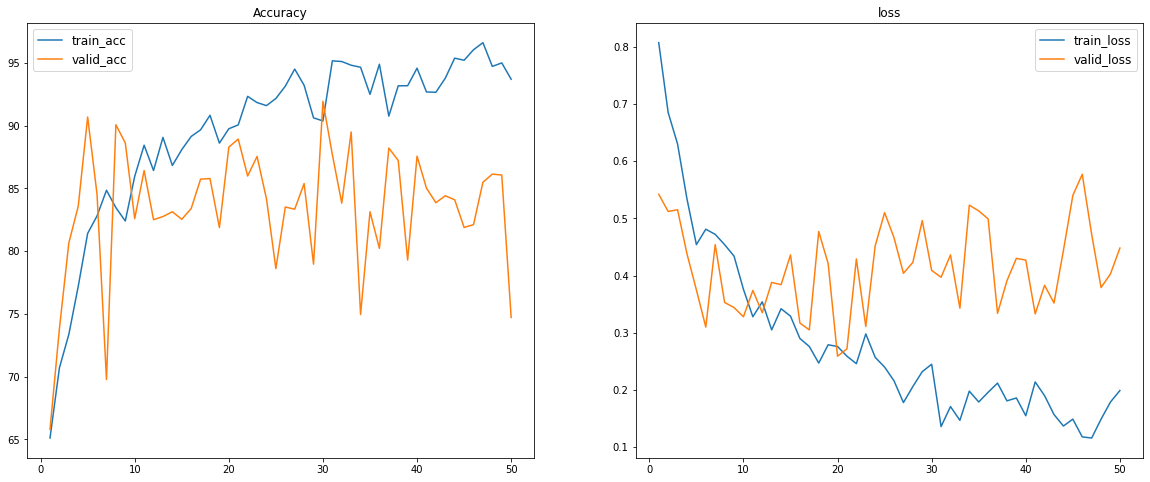

In [13]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np

fig, axes = plt.subplots( nrows = 1, ncols = 2, figsize = (20, 8) )
 
axes[0].plot(np.arange(1,len(train_acc_lst)+1), train_acc_lst, label = 'train_acc')
axes[0].plot(np.arange(1,len(test_acc_lst)+1), test_acc_lst, label = 'valid_acc')
axes[0].legend(fontsize=12)
axes[0].set_title('Accuracy')

axes[1].plot(np.arange(1,len(train_loss_lst)+1), train_loss_lst, label = 'train_loss')
axes[1].plot(np.arange(1,len(test_loss_lst)+1), test_loss_lst, label = 'valid_loss')
axes[1].legend(fontsize=12)
axes[1].set_title('loss')